In [1]:
from gplearn.genetic import SymbolicTransformer, SymbolicClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [3]:
df = pd.read_csv("Building_Permits.csv", low_memory=False)

In [4]:
df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Permit Number                           198900 non-null  object 
 1   Permit Type                             198900 non-null  int64  
 2   Permit Type Definition                  198900 non-null  object 
 3   Permit Creation Date                    198900 non-null  object 
 4   Block                                   198900 non-null  object 
 5   Lot                                     198900 non-null  object 
 6   Street Number                           198900 non-null  int64  
 7   Street Number Suffix                    2216 non-null    object 
 8   Street Name                             198900 non-null  object 
 9   Street Suffix                           196132 non-null  object 
 10  Unit                                    2947

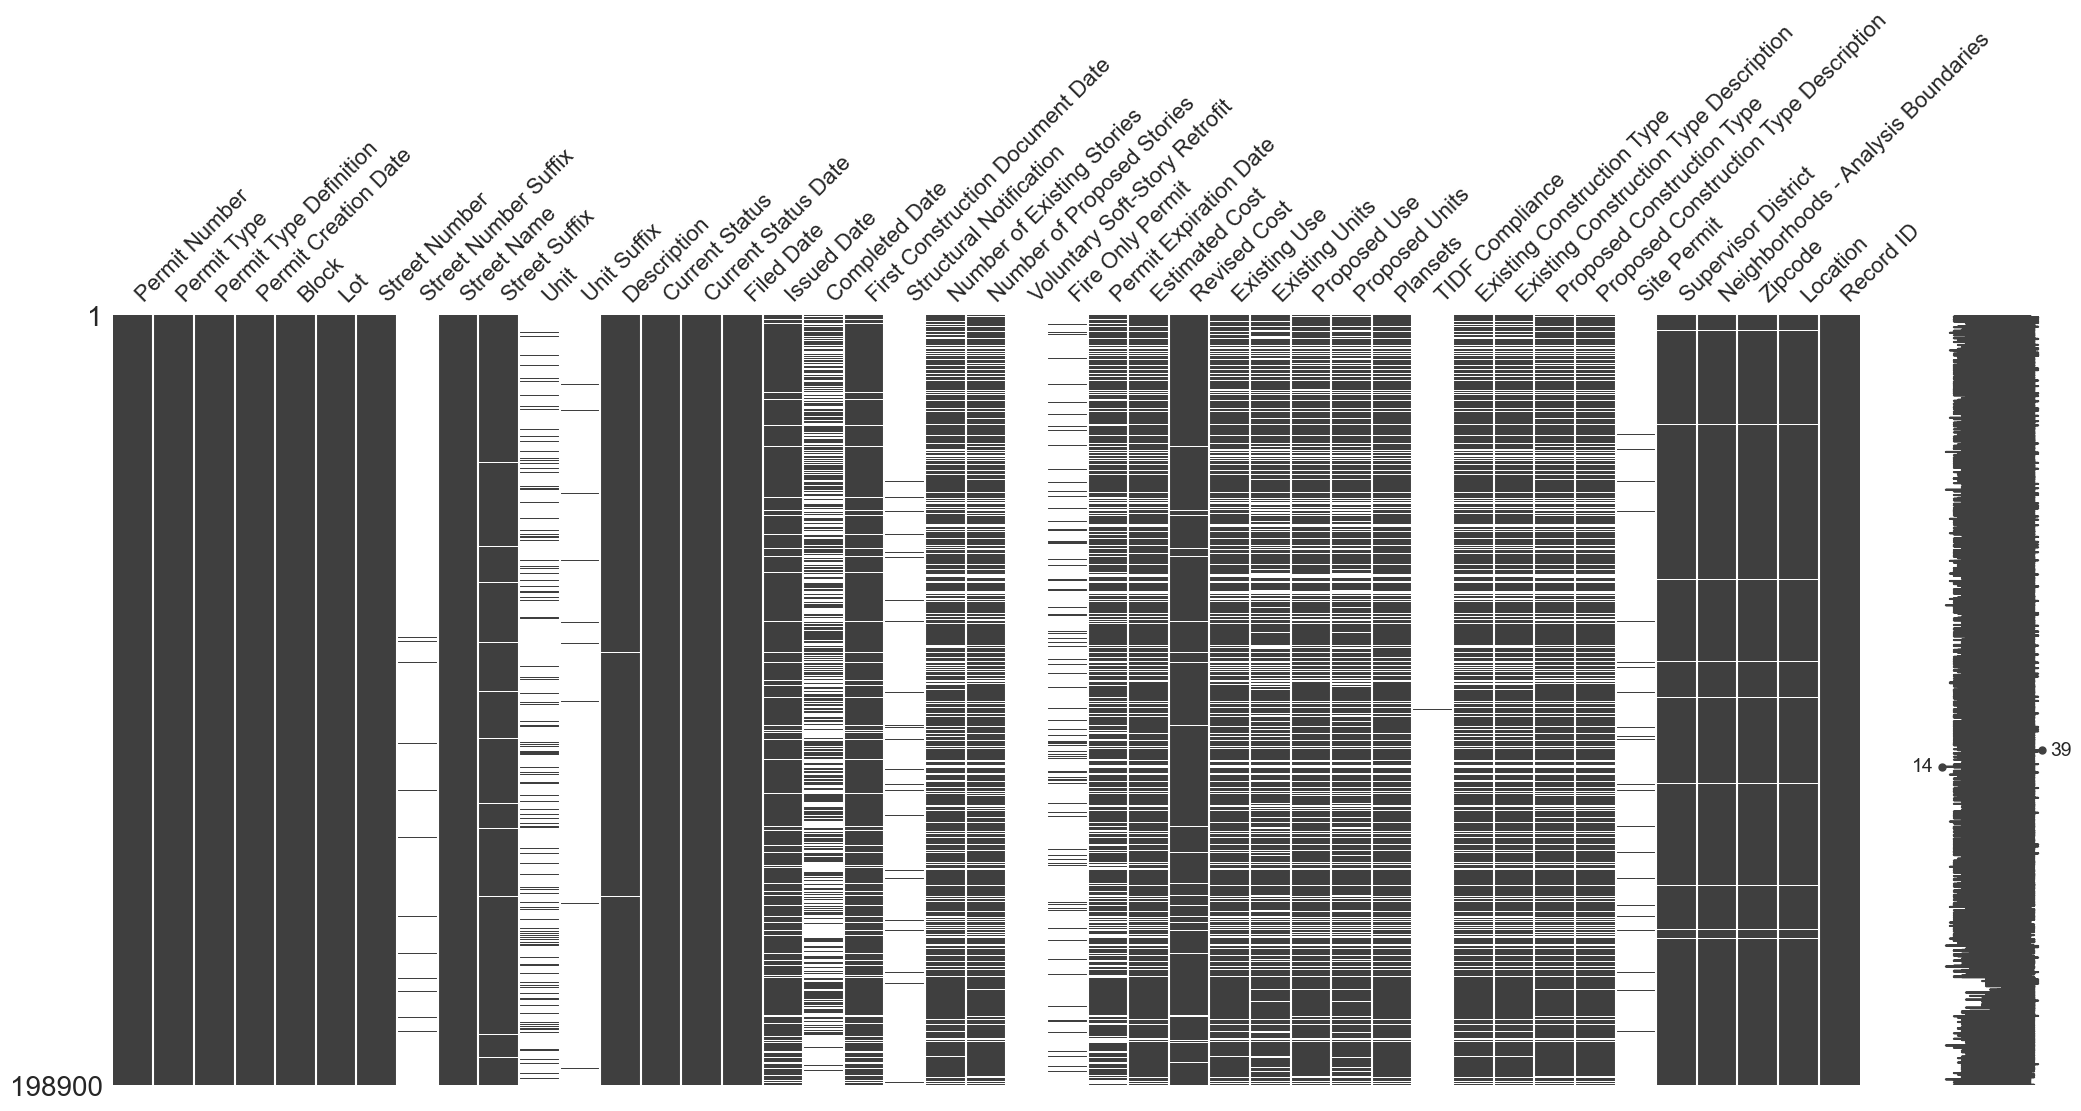

In [6]:
msno.matrix(df)
plt.show()

In [ ]:
df_encoded = pd.get_dummies(df, columns=["Permit Number", "Permit Type Definition", "Permit Creation Date", "Block", "Lot", "Street Number", "Street Number Suffix", "Street Name"])